## Imports & Loading

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

df = pd.read_csv('data/bank-full.csv', sep=';')

In [2]:
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


## Data Cleaning


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.y = (df.y == 'yes').astype(int)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


## EDA

In [5]:
# Check for missing values
print(df.isnull().sum())


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [4]:
# Look at the distribution of the target variable
df.y.value_counts(normalize=True)

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64

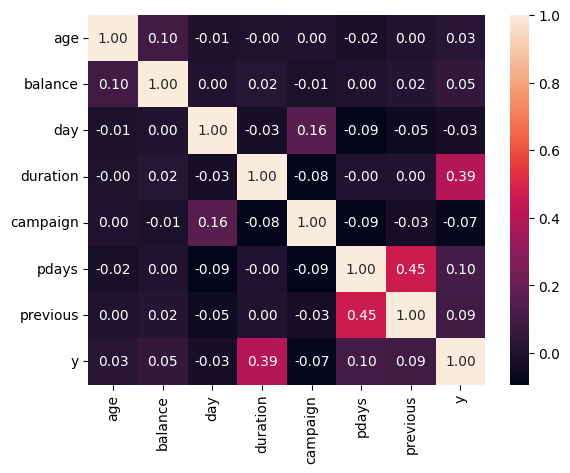

In [7]:
# Look at numerical correlations
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Validation Framework

In [21]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Parameter Tuning (XGBoost)

In [22]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Try different depths
for depth in [3, 6, 10]:
    model = XGBClassifier(max_depth=depth, n_estimators=100, learning_rate=0.1, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'Max Depth: {depth}, AUC: {auc:.4f}')

Max Depth: 3, AUC: 0.9213
Max Depth: 6, AUC: 0.9299
Max Depth: 10, AUC: 0.9273


## Feature Importance

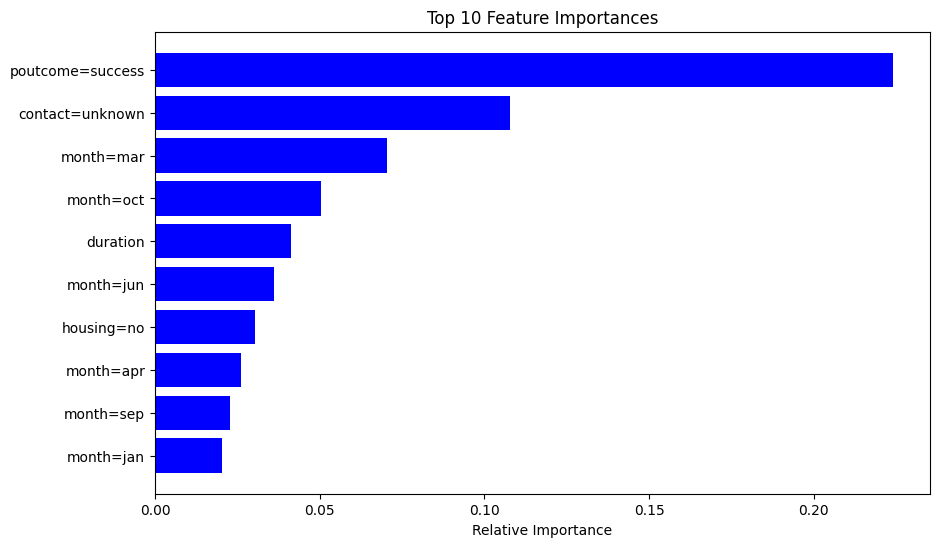

In [23]:
import matplotlib.pyplot as plt

# Get feature importance from XGBoost
features = dv.get_feature_names_out()
importances = model.feature_importances_

# Sort them for better visualization
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## ROC Curve & AUC Score

Observation: The dataset is imbalanced.

Only ~11.7% of customers subscribed. 

We will use AUC as our primary evaluation metric instead of Accuracy.

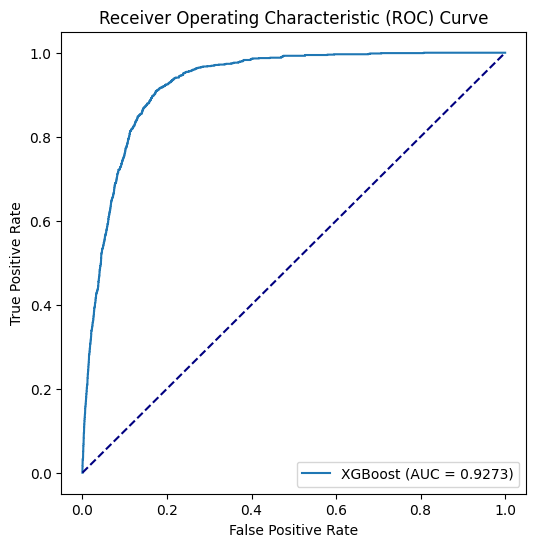

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_val, y_pred):.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()